In [0]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import keras
import string as st
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from google.colab import files
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt


***Run the code in google colab.***

# ***Neural Machine Translation from German to english using encoder decoder sequence model.***


# ***Dataset is restricted to 60000 records apporx. for this execution (total dataset is of 174481 records).***

I have generated the output in the csv file 'predicted.csv' which will be visible in the left pane on refreshing.

In [5]:
# convert data into dataframe  
data = pd.read_csv('deu.txt', delimiter='\t', names=['English', 'German'], usecols=[0,1])
dataCopy=data
data.head()

,English,German
0,Hi.,Hallo!
1,Hi.,Grüß Gott!
2,Run!,Lauf!
3,Wow!,Potzdonner!
4,Wow!,Donnerwetter!


In [0]:
data.shape
# restrict dataset to 35000 records
dataLimit = np.random.rand(len(dataCopy)) <= 0.29
limitDataset=dataCopy[dataLimit]

In [7]:
limitDataset.shape

(59424, 2)

In [8]:
#keras based tokenizer is used to map words to integer
tokenizerEn=Tokenizer()
tokenizerFr=Tokenizer()

tokenizerEn.fit_on_texts(limitDataset['English'].to_numpy())
vocabSizeEn = len(tokenizerEn.word_index) + 1

tokenizerFr.fit_on_texts(limitDataset['German'].to_numpy())
vocabSizeFr = len(tokenizerFr.word_index) + 1

print('Vocabulary Size: English ', vocabSizeEn, "German ", vocabSizeFr)

Vocabulary Size: English  10630 German  19360


In [9]:
#Data preprocessing to clean the data and get the maximum sized length of sentences from both languages
maxLenEn = 0
maxLenFr = 0
for index, row in limitDataset.iterrows():
    row['English']=row['English'].translate(str.maketrans('', '', st.punctuation)).lower()
    if len(row['English'].split())>maxLenEn:
        maxLenEn=len(row['English'].split())
    row['German']=row['German'].translate(str.maketrans('', '', st.punctuation)).lower()
    if len(row['German'].split())>maxLenFr:
        maxLenFr=len(row['German'].split())  
print("Maximum sized length : English ",maxLenEn,"German ", maxLenFr )

Maximum sized length : English  47 German  54


In [10]:
# we will split the data to keep 70:30 ratio for training and test data
splitData = np.random.rand(len(limitDataset)) <= 0.7
trainData = limitDataset[splitData]
testData = limitDataset[~splitData]
#check the data count in training set and test set
print("Training Data: ",trainData.shape," Test data: ",testData.shape)
# Data in to numpy array conversion
trainDataNP=trainData.to_numpy()
testDataNP=testData.to_numpy()

Training Data:  (41509, 2)  Test data:  (17915, 2)


**Data encoding is done i.e. converting text to ids and add padding to make all sequences of same length. **

In [0]:
def dataEncoder(allData, lanTokenizer, length):
    encodedData = lanTokenizer.texts_to_sequences(allData)
    paddedData = pad_sequences(encodedData, maxlen=length, padding='post')
    return paddedData

trainFr = dataEncoder(trainDataNP[:, 1],tokenizerFr,maxLenFr)
trainEn = dataEncoder(trainDataNP[:, 0],tokenizerEn,maxLenEn)
testFr = dataEncoder(testDataNP[:, 1],tokenizerFr,maxLenFr)
testEn = dataEncoder(testDataNP[:, 0],tokenizerEn,maxLenEn)

In [12]:
print(trainFr.shape, testFr.shape)

(41509, 54) (17915, 54)


In [13]:
#Sequence model
def sequenceModel(vocabFr, vocabEn, maxFr, maxEn, units):
    seqModel = Sequential()
    seqModel.add(Embedding(vocabFr, units, input_length=maxFr, mask_zero=True))
    seqModel.add(LSTM(units))
    seqModel.add(RepeatVector(maxEn))
    seqModel.add(LSTM(units, return_sequences=True))
    seqModel.add(Dense(vocabEn, activation='softmax'))
    return seqModel

seqModel = sequenceModel(vocabSizeFr, vocabSizeEn, maxLenFr, maxLenEn, 256)
rmsOptimizer = optimizers.RMSprop(lr=0.01)
seqModel.compile(optimizer=rmsOptimizer, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [14]:
modelPrediction = seqModel.fit(trainFr, trainEn.reshape(trainEn.shape[0], trainEn.shape[1], 1),epochs=15, batch_size=256, validation_split = 0.2, verbose=1)




Train on 33207 samples, validate on 8302 samples
Epoch 1/15





33207/33207 [==============================] - 286s 9ms/step - loss: 0.9871 - val_loss: 1.6052
Epoch 2/15
33207/33207 [==============================] - 278s 8ms/step - loss: 0.6121 - val_loss: 1.5474
Epoch 3/15
33207/33207 [==============================] - 280s 8ms/step - loss: 0.5162 - val_loss: 1.3303
Epoch 4/15
33207/33207 [==============================] - 280s 8ms/step - loss: 0.4346 - val_loss: 1.4199
Epoch 5/15
33207/33207 [==============================] - 279s 8ms/step - loss: 0.3675 - val_loss: 1.4233
Epoch 6/15
33207/33207 [==============================] - 279s 8ms/step - loss: 0.3304 - val_loss: 1.4409
Epoch 7/15
33207/33207 [==============================] - 279s 8ms/step - loss: 0.2908 - val_loss: 1.5234
Epoch 8/15
33207/33207 [==============================] - 281s 8ms/step - loss: 0.2592 - val_loss: 1.5192
Epoch 9/15
33207/33207 [==============================] - 276s 8ms/step - loss: 0.2328 - val_lo

In [0]:
#Get predictions for text data 
testPrediction = seqModel.predict_classes(testFr.reshape((testFr.shape[0],testFr.shape[1])))

In [0]:
## data decoder Convert mapped words in to normal words
def wordConversion(word_index, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == word_index:
            return word
    return None
    
def dataDecoder(prediction):
    textPredicted=list()
    for sentence in prediction:
        sentenceConverted = list()
        for word_index in range(len(sentence)):
            word = wordConversion(sentence[word_index], tokenizerEn)
            if word_index > 0:
                if (word == wordConversion(sentence[word_index-1], tokenizerEn)) or (word == None):
                    sentenceConverted.append('')
                else:
                    sentenceConverted.append(word)

            else:
                if(word == None):
                    sentenceConverted.append('')
                else:
                    sentenceConverted.append(word)            

        textPredicted.append(' '.join(sentenceConverted))
        
    return textPredicted

In [0]:
#calling data decoder for the predictions
predictedText = dataDecoder(testPrediction)
predictedDataframe = pd.DataFrame({'German text': testData['German'],' Expected text' : testData['English'], 'Predicted text' : predictedText})

# ***Data after conversion from German to english i.e. both the expected and predicted english text***

In [18]:

predictedDataframe.head(10)

,German text,Expected text,Predicted text
17,ich habe gewonnen,i won,i have won ...
41,ich zahlte,i paid,i study ...
44,ich bin 19 jahre alt,im 19,young old thirty ...
50,unmöglich,no way,impossible pain ...
76,mach dich fort,beat it,go away ...
78,mach dich vom acker,beat it,get lost ...
102,geh weg,go away,go away ...
118,scher dich fort,go away,go away ...
121,hau ab,go away,go fly a kite ...
122,verschwinde,go away,get away ...


# ***Using corpus bleu function to calculate the Bleu score for data***

In [19]:
print('BLEU score using corpus bleu function:',corpus_bleu(testDataNP[:,0], predictedText))

BLEU score using corpus bleu function: 0.6274436101316149


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


## ***Ploting training and validation losses***



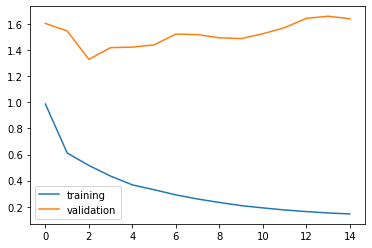

In [22]:
plt.plot(modelPrediction.history['loss'])
plt.plot(modelPrediction.history['val_loss'])
plt.legend(['training','validation'])
plt.show()